In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import random
import igraph as ig
import os



def read_dimacs_graph(filename):
    edges = []
    weights = []
    max_node = 0
    
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("a"):
                _, u, v, w = line.strip().split()
                u, v, w = int(u), int(v), int(w)
                edges.append((u - 1, v - 1))
                weights.append(w)
                max_node = max(max_node, u, v)


    G = ig.Graph()
    G.add_vertices(max_node)
    G.add_edges(edges)
    G.es["weight"] = weights
    return G


def save_dimacs_graph(G: ig.Graph, filename, comment: str = ""):
    with open(filename, "w") as f:
        if not comment.isspace():
            f.write(f"c {comment}\n")
        f.write(f"p sp {G.vcount()} {G.ecount()}\n")
        for e in G.es:
            u, v = G.es[e.index].tuple
            w = e["weight"] if "weight" in e.attributes() else 1
            f.write(f"a {u + 1} {v + 1} {w}\n")

In [4]:
def remove_edges(G: ig.Graph, remove_percent=0.1):
    assert 0 < remove_percent < 1

    remove_edges_count = int(G.ecount() * remove_percent)
    # print(f"Will be removed: {remove_edges_count} edges.")

    h_edges = list(G.es)

    bridge_ids = set(G.bridges())
    sorted_edges = [
    (e.source, e.target, e["weight"] if "weight" in e.attributes() else 1)
    for e in h_edges
    if e.index not in bridge_ids
    ]
    sorted_edges = sorted(sorted_edges, key=lambda x: x[2])

    result_graph: ig.Graph = G.copy()

    degrees = {v.index: deg for v, deg in zip(result_graph.vs, result_graph.degree())}
    edges_to_remove = set()

    while len(edges_to_remove) < remove_edges_count and sorted_edges:
        u, v, _ = sorted_edges.pop()

        if degrees[u] <= 1 or degrees[v] <= 1:
            continue

        degrees[u] -= 1
        degrees[v] -= 1

        edges_to_remove.add((u, v))

    result_graph.delete_edges(edges_to_remove)

    # print(f"Was: {G.ecount()}, Now: {result_graph.ecount()} (edges). It is {(G.ecount() - result_graph.ecount()) / G.ecount() * 100:.2f}% of the original number.")
    return result_graph

# Experiment 1 (Density)

In [5]:
exp_dataset = {
    "San Francisco Bay Area": "USA-road-d.BAY.gr",
    "California and Nevada": "USA-road-d.CAL.gr",
    "Colorado": "USA-road-d.COL.gr",
    "Florida": "USA-road-d.FLA.gr",
    "Great Lakes": "USA-road-d.LKS.gr",
    "Northeast USA": "USA-road-d.NE.gr",
    "Northwest USA": "USA-road-d.NW.gr",
    "New York City": "USA-road-d.NY.gr",
}

In [ ]:
def calc_density(G: ig.Graph):
    return (2 * G.ecount()) / (G.vcount() * (G.vcount() - 1))


# Experiment 1

PERCENTS = [0.01, 0.03, 0.05, 0.07, 0.1, 0.13, 0.15]

for name, filename in tqdm.tqdm(exp_dataset.items()):
    G = read_dimacs_graph(filename)

    for percent in PERCENTS:
        G2 = remove_edges(G, percent)

        assert len(list(G2.connected_components(mode="strong"))) == 1

        new_name = (
            os.path.splitext(os.path.basename(filename))[0]
            + f".perc_{int(percent * 100)}.gr"
        )

        save_dimacs_graph(
            G2,
            f"dataset/{new_name}",
            comment=f"Name: {name}, Filename: {filename} Density: {calc_density(G2)}, Start density: {calc_density(G)}",
        )


100%|██████████| 8/8 [10:09<00:00, 76.14s/it] 


# Experiment 2 (Weights)

In [ ]:
def scale(weights):
    min_w = np.min(weights)
    max_w = np.max(weights)
    scaled = (weights - min_w) / (max_w - min_w) * 100
    return scaled.astype(int)

for name, filename in tqdm.tqdm(exp_dataset.items()):
    G = read_dimacs_graph(filename)
    edges_count = len(G.es)

    # Нормальное распределение
    uniform_weights = scale(np.random.randint(0, 100, size=(edges_count)))
    # G.es['weight'] = uniform_weights
    # new_name = (os.path.splitext(os.path.basename(filename))[0] + ".uniform.gr")
    # save_dimacs_graph(G,f"dataset/{new_name}")

    # Логнормальное распределение
    lognorm_weights = scale(np.random.lognormal(mean=0, sigma=0.15, size=edges_count))
    # G.es['weight'] = lognorm_weights
    # new_name = (os.path.splitext(os.path.basename(filename))[0] + ".lognorm.gr")
    # save_dimacs_graph(G,f"dataset/{new_name}")

    # Нормальное распределение
    exp_weights = scale(np.random.exponential(scale=0.75, size=edges_count))
    # G.es['weight'] = exp_weights
    # new_name = (os.path.splitext(os.path.basename(filename))[0] + ".exp.gr")
    # save_dimacs_graph(G,f"dataset/{new_name}")

    # Распределение Пуассона
    default_weights = scale(G.es['weight'])
    G.es['weight'] = default_weights
    # new_name = (os.path.splitext(os.path.basename(filename))[0] + ".default.gr")
    # save_dimacs_graph(G,f"dataset/{new_name}")

100%|██████████| 8/8 [00:22<00:00,  2.86s/it]


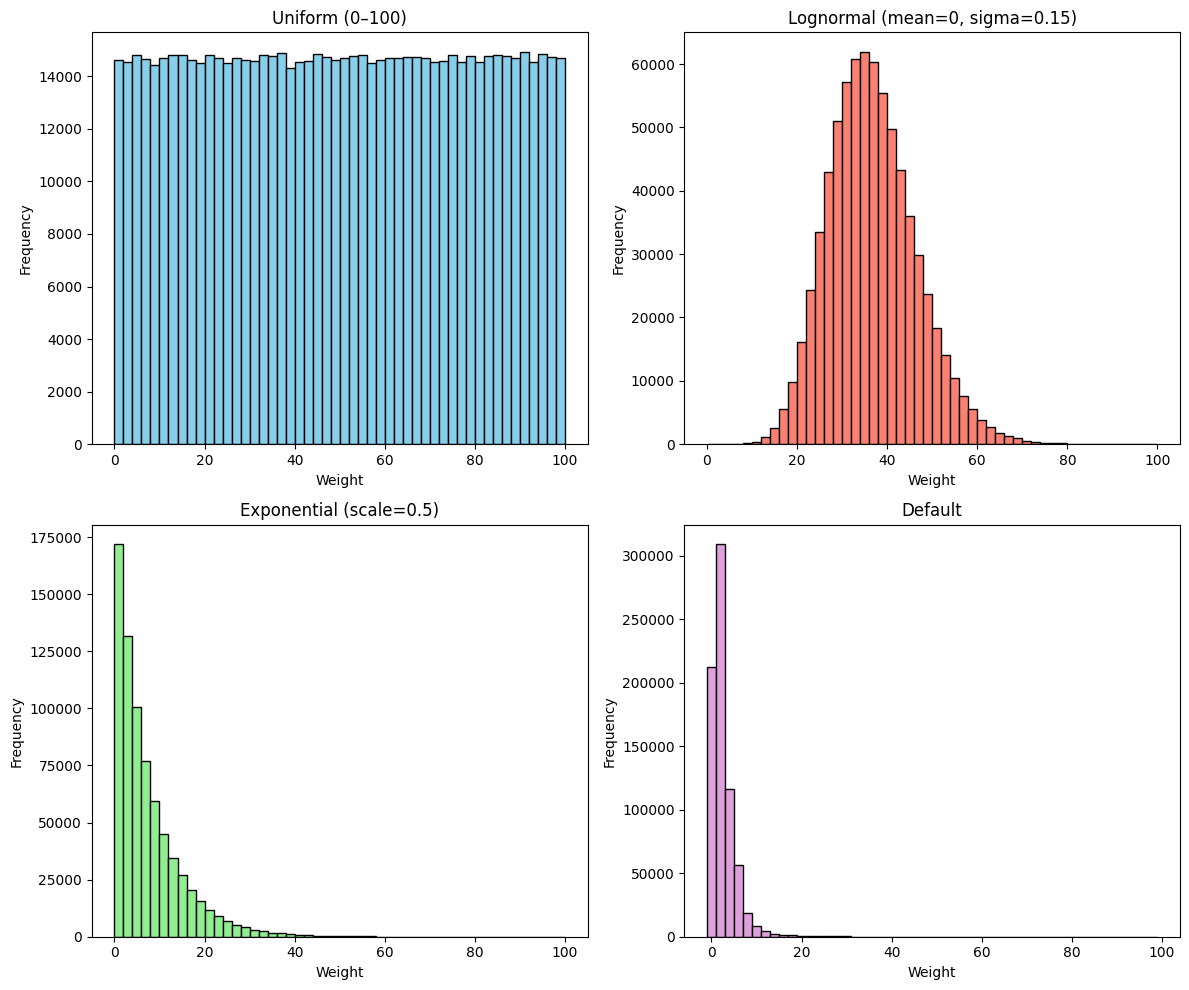

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Uniform
axs[0,0].hist(uniform_weights, bins=50, color='skyblue', edgecolor='black')
axs[0,0].set_title("Uniform (0–100)")

# Lognormal
axs[0,1].hist(lognorm_weights, bins=50, color='salmon', edgecolor='black')
axs[0,1].set_title("Lognormal (mean=0, sigma=0.15)")

# Exponential
axs[1,0].hist(exp_weights, bins=50, color='lightgreen', edgecolor='black')
axs[1,0].set_title("Exponential (scale=0.5)")

# Poisson
axs[1,1].hist(default_weights, bins=50, color='plum', edgecolor='black', align='left')
axs[1,1].set_title("Default")

for ax in axs.flat:
    ax.set_xlabel("Weight")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()